In [ ]:
! pip install xgboost

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold,RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import uniform, randint
import imblearn

In [ ]:
path = "/content/drive/MyDrive/datasets/diabetes with 2000 samples.csv"
data = pd.read_csv(path)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [ ]:
np.set_printoptions(threshold = sys.maxsize)

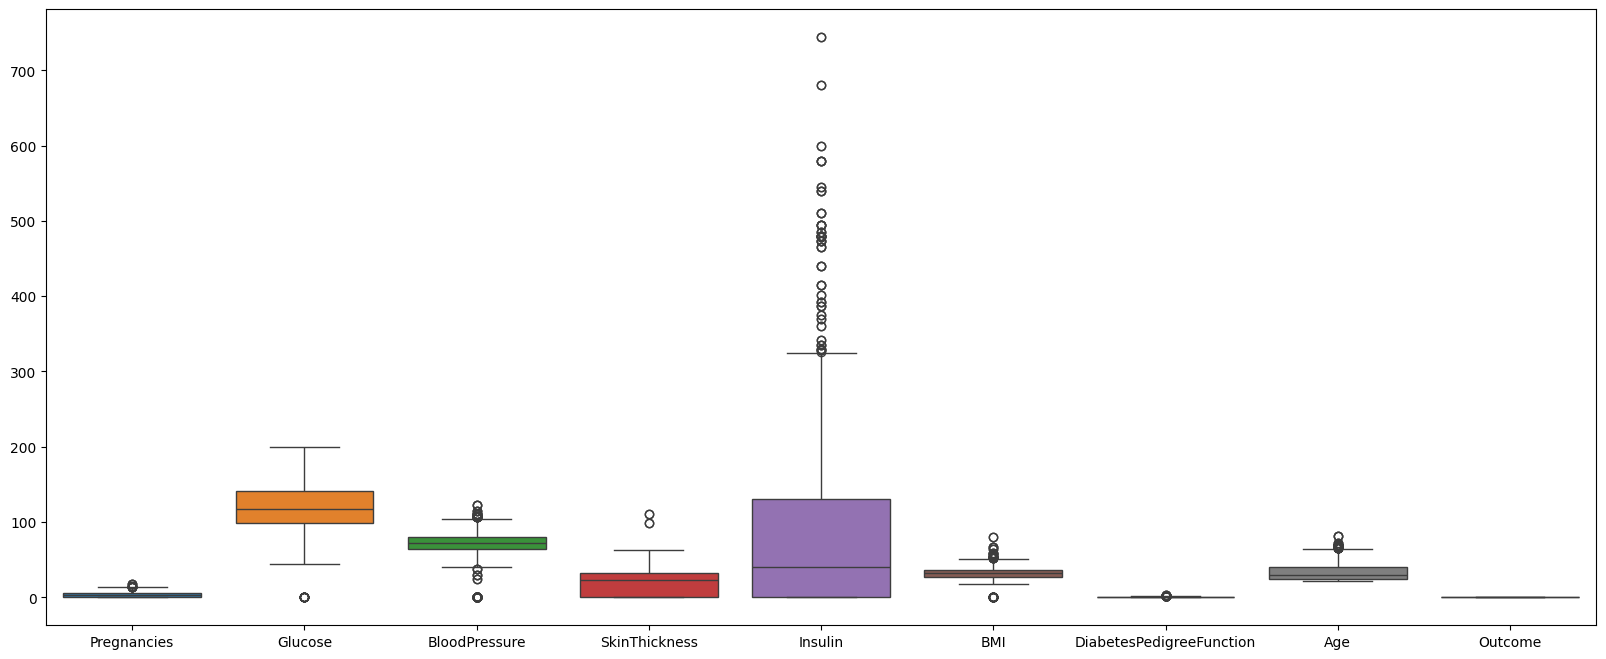

In [ ]:
plt.figure(figsize=(20, 8))
sb.boxplot(data= data)
plt.show()

In [ ]:
Q1 = data[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']].quantile(0.25)
Q3 = data[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']].quantile(0.75)
IQR = Q3 - Q1

outliers = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

data_without_outliers = data[~((data[outliers] < (Q1 - 1.5 * IQR)) | (data[outliers] > (Q3 + 1.5 * IQR))).any(axis=1)]

data_without_outliers

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
3,0,135,68,42,250,42.3,0.365,24,1
5,0,173,78,32,265,46.5,1.159,58,0
6,4,99,72,17,0,25.6,0.294,28,0
...,...,...,...,...,...,...,...,...,...
1994,1,79,60,42,48,43.5,0.678,23,0
1995,2,75,64,24,55,29.7,0.370,33,0
1996,8,179,72,42,130,32.7,0.719,36,1
1997,6,85,78,0,0,31.2,0.382,42,0


In [ ]:
data_without_outliers = data_without_outliers.reset_index()
data_without_outliers.drop(['index'],axis = 1,inplace = True)
data_without_outliers

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,135,68,42,250,42.3,0.365,24,1
3,0,173,78,32,265,46.5,1.159,58,0
4,4,99,72,17,0,25.6,0.294,28,0
...,...,...,...,...,...,...,...,...,...
1647,1,79,60,42,48,43.5,0.678,23,0
1648,2,75,64,24,55,29.7,0.370,33,0
1649,8,179,72,42,130,32.7,0.719,36,1
1650,6,85,78,0,0,31.2,0.382,42,0


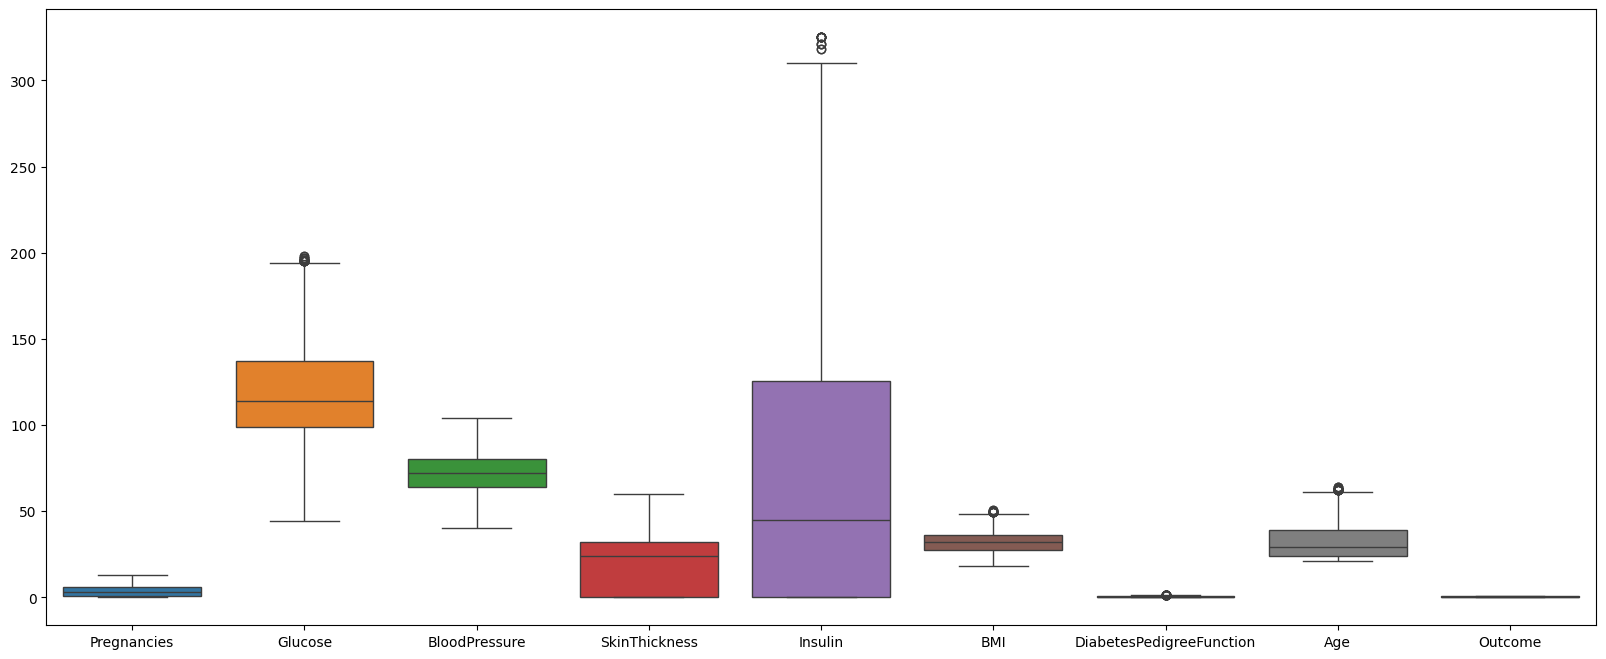

In [ ]:
plt.figure(figsize=(20, 8))
sb.boxplot(data= data_without_outliers)
plt.show()

In [ ]:
X = data_without_outliers.iloc[:,:-1]
y = data_without_outliers.iloc[:,-1]

In [ ]:
columns_to_replace = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction']
X[columns_to_replace] = X[columns_to_replace].replace(0,np.nan)
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2,138,62,35.0,NaN,33.6,0.127,47
1,0,84,82,31.0,125.0,38.2,0.233,23
2,0,135,68,42.0,250.0,42.3,0.365,24
3,0,173,78,32.0,265.0,46.5,1.159,58
4,4,99,72,17.0,NaN,25.6,0.294,28
...,...,...,...,...,...,...,...,...
1647,1,79,60,42.0,48.0,43.5,0.678,23
1648,2,75,64,24.0,55.0,29.7,0.370,33
1649,8,179,72,42.0,130.0,32.7,0.719,36
1650,6,85,78,NaN,NaN,31.2,0.382,42


In [ ]:
imputer = KNNImputer(n_neighbors=3)
X = imputer.fit_transform(X)
X

array([[2.00000000e+00, 1.38000000e+02, 6.20000000e+01, 3.50000000e+01,
        1.40000000e+02, 3.36000000e+01, 1.27000000e-01, 4.70000000e+01],
       [0.00000000e+00, 8.40000000e+01, 8.20000000e+01, 3.10000000e+01,
        1.25000000e+02, 3.82000000e+01, 2.33000000e-01, 2.30000000e+01],
       [0.00000000e+00, 1.35000000e+02, 6.80000000e+01, 4.20000000e+01,
        2.50000000e+02, 4.23000000e+01, 3.65000000e-01, 2.40000000e+01],
       [0.00000000e+00, 1.73000000e+02, 7.80000000e+01, 3.20000000e+01,
        2.65000000e+02, 4.65000000e+01, 1.15900000e+00, 5.80000000e+01],
       [4.00000000e+00, 9.90000000e+01, 7.20000000e+01, 1.70000000e+01,
        7.00000000e+01, 2.56000000e+01, 2.94000000e-01, 2.80000000e+01],
       [2.00000000e+00, 8.30000000e+01, 6.50000000e+01, 2.80000000e+01,
        6.60000000e+01, 3.68000000e+01, 6.29000000e-01, 2.40000000e+01],
       [2.00000000e+00, 8.90000000e+01, 9.00000000e+01, 3.00000000e+01,
        1.80000000e+02, 3.35000000e+01, 2.92000000e-01, 4.

In [ ]:
X_df = pd.DataFrame(X,columns=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age'])
X_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2.0,138.0,62.0,35.000000,140.000000,33.6,0.127,47.0
1,0.0,84.0,82.0,31.000000,125.000000,38.2,0.233,23.0
2,0.0,135.0,68.0,42.000000,250.000000,42.3,0.365,24.0
3,0.0,173.0,78.0,32.000000,265.000000,46.5,1.159,58.0
4,4.0,99.0,72.0,17.000000,70.000000,25.6,0.294,28.0
...,...,...,...,...,...,...,...,...
1647,1.0,79.0,60.0,42.000000,48.000000,43.5,0.678,23.0
1648,2.0,75.0,64.0,24.000000,55.000000,29.7,0.370,33.0
1649,8.0,179.0,72.0,42.000000,130.000000,32.7,0.719,36.0
1650,6.0,85.0,78.0,27.333333,75.666667,31.2,0.382,42.0


In [ ]:
new_data = pd.concat([X_df,y],axis = 1)
new_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2.0,138.0,62.0,35.000000,140.000000,33.6,0.127,47.0,1
1,0.0,84.0,82.0,31.000000,125.000000,38.2,0.233,23.0,0
2,0.0,135.0,68.0,42.000000,250.000000,42.3,0.365,24.0,1
3,0.0,173.0,78.0,32.000000,265.000000,46.5,1.159,58.0,0
4,4.0,99.0,72.0,17.000000,70.000000,25.6,0.294,28.0,0
...,...,...,...,...,...,...,...,...,...
1647,1.0,79.0,60.0,42.000000,48.000000,43.5,0.678,23.0,0
1648,2.0,75.0,64.0,24.000000,55.000000,29.7,0.370,33.0,0
1649,8.0,179.0,72.0,42.000000,130.000000,32.7,0.719,36.0,1
1650,6.0,85.0,78.0,27.333333,75.666667,31.2,0.382,42.0,0


In [ ]:
X_1 = new_data.iloc[:,:-1].values
y_1 = new_data.iloc[:,-1].values

In [ ]:
ss = StandardScaler()
X_1 = ss.fit_transform(X_1)

In [ ]:
X_df_1 = pd.DataFrame(X,columns=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age'])
X_df_1

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2.0,138.0,62.0,35.000000,140.000000,33.6,0.127,47.0
1,0.0,84.0,82.0,31.000000,125.000000,38.2,0.233,23.0
2,0.0,135.0,68.0,42.000000,250.000000,42.3,0.365,24.0
3,0.0,173.0,78.0,32.000000,265.000000,46.5,1.159,58.0
4,4.0,99.0,72.0,17.000000,70.000000,25.6,0.294,28.0
...,...,...,...,...,...,...,...,...
1647,1.0,79.0,60.0,42.000000,48.000000,43.5,0.678,23.0
1648,2.0,75.0,64.0,24.000000,55.000000,29.7,0.370,33.0
1649,8.0,179.0,72.0,42.000000,130.000000,32.7,0.719,36.0
1650,6.0,85.0,78.0,27.333333,75.666667,31.2,0.382,42.0


In [ ]:
Kernel_PCA = KernelPCA(n_components=4,random_state=42)
data_pca = Kernel_PCA.fit_transform(X_df_1)
data_pca

array([[ 1.52009040e+01,  1.59088710e+01,  1.21215844e+00,
         4.03410394e+00],
       [-1.35632724e+01, -3.23762851e+01,  9.09464029e+00,
        -8.31371938e+00],
       [ 1.20404859e+02, -1.81049235e+01, -3.54242381e+00,
        -1.50219939e+01],
       [ 1.45734275e+02,  1.89621607e+01,  1.17874720e+01,
         9.80363921e+00],
       [-6.36215346e+01, -4.13292533e+00, -4.80861519e+00,
         6.49173956e+00],
       [-7.11973782e+01, -1.93593146e+01, -2.06859630e+00,
        -6.86394179e+00],
       [ 4.12800562e+01, -3.90415286e+01,  2.18499391e+01,
         8.27021275e+00],
       [-5.42360284e+01, -5.87984982e+00,  5.87230120e+00,
        -6.17089305e+00],
       [-6.16800023e+00,  8.65998162e+00, -5.83873102e-01,
         1.57702201e+01],
       [-2.25733017e+01, -4.08473448e+00, -4.77470246e+00,
         3.14261710e+00],
       [-6.25702132e+01, -2.32854696e+01, -3.85780606e+00,
         5.14975359e+00],
       [ 3.50050503e+01,  7.06704280e+01, -2.29933636e-01,
      

In [ ]:
final_data = pd.DataFrame(data_pca,columns=['Feature_1','Feature_2','Feature_3','Feature_4'])
y_1 = pd.Series(y_1,name="Outcome")
final_data = pd.concat([final_data,y_1],axis = 1)
final_data

,Feature_1,Feature_2,Feature_3,Feature_4,Outcome
0,15.200904,15.908871,1.212158,4.034104,1
1,-13.563272,-32.376285,9.094640,-8.313719,0
2,120.404859,-18.104923,-3.542424,-15.021994,1
3,145.734275,18.962161,11.787472,9.803639,0
4,-63.621535,-4.132925,-4.808615,6.491740,0
...,...,...,...,...,...
1647,-89.014663,-18.822323,2.423986,-19.539706,0
1648,-84.015639,-23.150553,0.245203,4.459933,0
1649,16.448969,57.550317,-0.792526,-9.528046,1
1650,-60.731822,-16.421344,14.706528,8.002324,0


In [ ]:
X_data = final_data.iloc[:,:-1]
y_data = final_data.iloc[:,-1]

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X_data,y_data,test_size=0.25,random_state = 42)

In [ ]:
print(np.unique(y_train,return_counts = True))

(array([0, 1]), array([863, 376]))


In [ ]:
ros = RandomOverSampler(random_state=42)

In [ ]:
X_train_ros , y_train_ros = ros.fit_resample(X_train,y_train)

In [ ]:
print(np.unique(y_train_ros,return_counts = True))

(array([0, 1]), array([863, 863]))


In [ ]:
params = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

random_search = RandomizedSearchCV(XGBClassifier(), param_distributions=params, n_iter=500, scoring='accuracy', cv=5, n_jobs=-1, random_state=42)
random_search.fit(X_train_ros, y_train_ros)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x785a6766b940>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x785a66df6110>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x785a66df50f0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x785a67668160>},
                   random_state=42, scoring='accuracy')

In [ ]:
print(random_search.best_params_)

{'colsample_bytree': 0.7101152853807441, 'gamma': 0.07810328434331099, 'learning_rate': 0.20078209804801325, 'max_depth': 6, 'n_estimators': 192, 'reg_alpha': 0.204166559168243, 'reg_lambda': 0.042342278772383835, 'subsample': 0.8318904628388899}


In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(colsample_bytree = 0.8430220889174291,gamma = 0.12217657773232726,learning_rate = 0.15947430935468207,max_depth = 8,n_estimators = 170,reg_alpha = 0.23722679173599448,reg_lambda = 0.10178247262040374,subsample = 0.6611436556737328)

In [ ]:
xgb = xgb.fit(X_train_ros,y_train_ros)

In [ ]:
y_predict_train = xgb.predict(X_train_ros)

In [ ]:
print(classification_report(y_true = y_train_ros,y_pred = y_predict_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       863
           1       1.00      1.00      1.00       863

    accuracy                           1.00      1726
   macro avg       1.00      1.00      1.00      1726
weighted avg       1.00      1.00      1.00      1726



In [ ]:
print(accuracy_score(y_train_ros,y_predict_train))

1.0


In [ ]:
print(confusion_matrix(y_train_ros,y_predict_train))

[[863   0]
 [  0 863]]


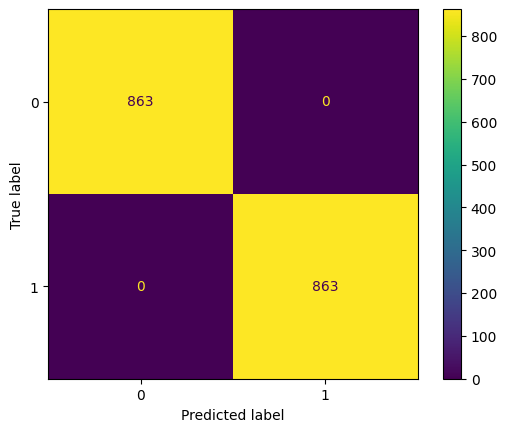

In [ ]:
confusion_matrix_train = confusion_matrix(y_train_ros,y_predict_train)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_train, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [ ]:
y_predict_test = xgb.predict(X_test)

In [ ]:
print(classification_report(y_test,y_predict_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       273
           1       1.00      0.92      0.96       140

    accuracy                           0.97       413
   macro avg       0.98      0.96      0.97       413
weighted avg       0.97      0.97      0.97       413



In [ ]:
print(accuracy_score(y_test,y_predict_test))

0.9733656174334141


In [ ]:
print(confusion_matrix(y_test,y_predict_test))

[[273   0]
 [ 11 129]]


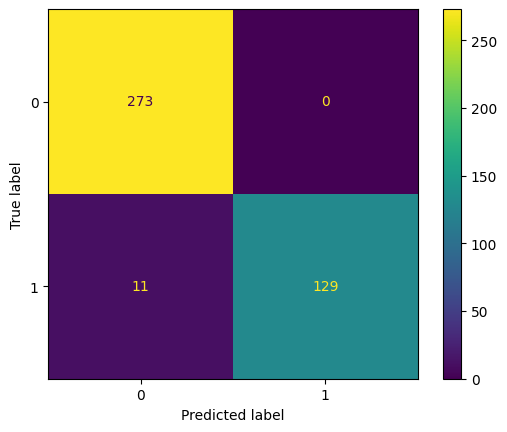

In [ ]:
confusion_matrix_test = confusion_matrix(y_test,y_predict_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [ ]:
y_pred_prob = xgb.predict_proba(X_test)[:,1]
fpr , tpr , threshold = roc_curve(y_test,y_pred_prob)

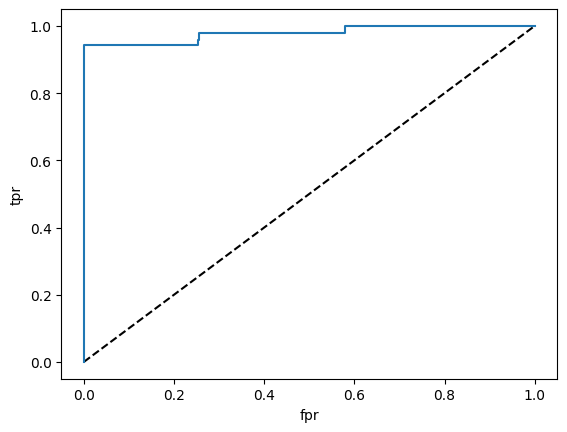

In [ ]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

In [ ]:
roc_auc_score(y_test,y_pred_prob)

0.9784929356357928

In [ ]:
k_folds = KFold(n_splits=5)
cv_scores = cross_val_score(xgb,X_train_ros,y_train_ros, cv = k_folds)

In [ ]:
summ = 0
for i in range(0,len(cv_scores)):
  summ += cv_scores[i]
print(f"mean accuracy is {round(summ / len(cv_scores),3)}")

mean accuracy is 0.972
